### Проект 3 [Медицинские расходы]

Вам предоставляется набор данных, содержащий информацию о медицинских расходах. Набор данных уже разделен на ```train.csv``` и ```test.csv```. Файл ```data_description.txt``` содержит описание столбцов.

**Цель:** построить модели для прогнозирования **медицинских расходов** (```"charges"```).

Пожалуйста, включите подробные объяснения следующих шагов:

1. Очистка, предварительная обработка данных

2. Обучение и проверка моделей.

3. Сравнение моделей на основе метрик регрессии.

**Примечание:** вам **рекомендуется** искать другие алгоритмы машинного обучения в Интернете (не ограничиваясь материалом курса), но вы должны изучить и понять эти алгоритмы. Вы не можете удалить ни одну строку в файле ```test.csv```.

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# Просмотр данных

In [2]:
train = pd.read_csv('train.csv')
train

,age,sex,bmi,children,smoker,region,charges
0,34,male,42.900,1,no,southwest,4536.25900
1,61,female,36.385,1,yes,northeast,48517.56315
2,60,male,25.740,0,no,southeast,12142.57860
3,44,female,29.810,2,no,southeast,8219.20390
4,40,female,29.600,0,no,southwest,5910.94400
...,...,...,...,...,...,...,...
1200,44,female,27.500,1,no,southwest,7626.99300
1201,37,female,17.290,2,no,northeast,6877.98010
1202,21,female,25.800,0,no,southwest,2007.94500
1203,30,male,38.830,1,no,southeast,18963.17192


In [3]:
test = pd.read_csv('test.csv')
test

,age,sex,bmi,children,smoker,region,charges
0,57,female,31.160,0,yes,northwest,43578.93940
1,61,female,39.100,2,no,southwest,14235.07200
2,61,male,23.655,0,no,northeast,13129.60345
3,59,male,29.700,2,no,southeast,12925.88600
4,19,female,28.880,0,yes,northwest,17748.50620
...,...,...,...,...,...,...,...
128,56,male,40.300,0,no,southwest,10602.38500
129,61,female,22.040,0,no,northeast,13616.35860
130,49,female,42.680,2,no,southeast,9800.88820
131,43,male,27.360,3,no,northeast,8606.21740


In [4]:
test_vol = round(test.shape[0] / (train.shape[0] + test.shape[0]), 2) * 100
train_vol = 100 - test_vol
print(f'test: {test_vol}%')
print(f'train: {train_vol}%')

test: 10.0%
train: 90.0%


<b>Данные train и test в соотоношении 9 : 1.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1205 non-null   int64  
 1   sex       1205 non-null   object 
 2   bmi       1205 non-null   float64
 3   children  1205 non-null   int64  
 4   smoker    1205 non-null   object 
 5   region    1205 non-null   object 
 6   charges   1205 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.0+ KB


In [6]:
train.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
print('Duplicated rows:', train.duplicated().sum())
train[train.duplicated() == True]

Duplicated rows: 1


,age,sex,bmi,children,smoker,region,charges
363,19,male,30.59,0,no,northwest,1639.5631


<b>Как видно, нулевые значения в данных train отсутствуют и есть 1 дубликат, который можно удалить:

In [8]:
train = train.drop_duplicates()
train.shape

(1204, 7)

# EDA

<b>Для того, чтобы посмотреть, имеется ли зависимость между расходами и всеми остальными параметрами в данных train, сделаем кодировку категорийных данных колонок sex, smoker и region в train и test.

### Кодировка категорийных данных

In [9]:
encoder = LabelEncoder()

encoder.fit(train.sex)
train.sex = encoder.transform(train.sex)
encoder.fit(train.smoker)
train.smoker = encoder.transform(train.smoker)
encoder.fit(train.region)
train.region = encoder.transform(train.region)

encoder.fit(test.sex)
test.sex = encoder.transform(test.sex)
encoder.fit(test.smoker)
test.smoker = encoder.transform(test.smoker)
encoder.fit(test.region)
test.region = encoder.transform(test.region)

train.head()

,age,sex,bmi,children,smoker,region,charges
0,34,1,42.900,1,0,3,4536.25900
1,61,0,36.385,1,1,0,48517.56315
2,60,1,25.740,0,0,2,12142.57860
3,44,0,29.810,2,0,2,8219.20390
4,40,0,29.600,0,0,3,5910.94400


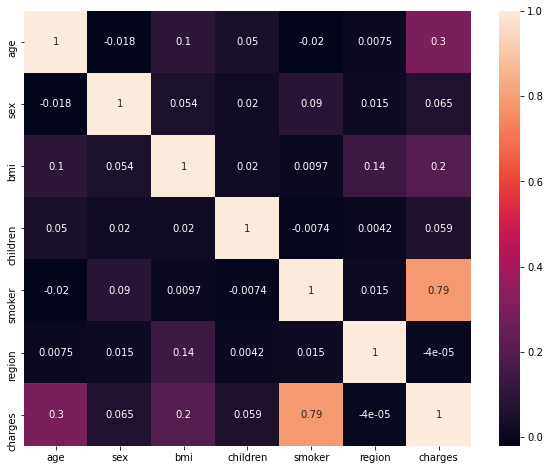

In [10]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), annot=True);

In [11]:
train.corr()['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.785939
age         0.295621
bmi         0.204721
sex         0.065092
children    0.058812
region     -0.000040
Name: charges, dtype: float64

<b>Как видно имеется только одна явная зависимость расходов от параметра smoker с коэфициентом корреляции 0.79.

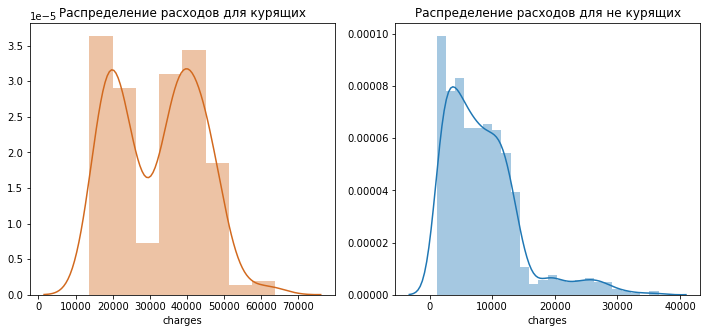

In [12]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
sns.distplot(train[train['smoker'] == 1]['charges'], color='chocolate', ax=ax);
ax.set_title('Распределение расходов для курящих')

ax = fig.add_subplot(122)
sns.distplot(train[train['smoker'] == 0]['charges'], ax=ax);
ax.set_title('Распределение расходов для не курящих');

<b>Как видно из диаграммы курящие тратят на лечение больше, чем не курящие, но по колличеству в данных курящих меньше, чем не курящих:

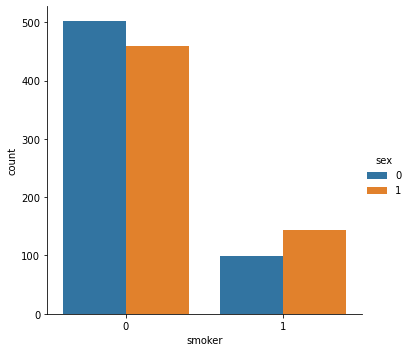

In [13]:
sns.catplot(x='smoker', kind='count', hue='sex', data=train);

<b>Расшифровка:
- Smoker: курящий - 1, не курящий - 0
- Sex: мужчина - 1, женщина - 0
    
Также удобно посмотреть распределение цены в форме "скрипок" для курящих и не курящих, мужского и женского полов на следующем графике:

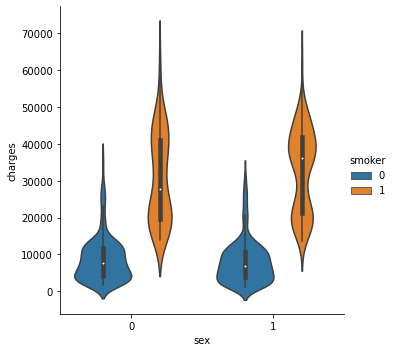

In [14]:
sns.catplot(x='sex', y='charges', hue='smoker', kind='violin', data=train);

<b>Распределение цены в зависимости от возраста для курящих и не курящих:

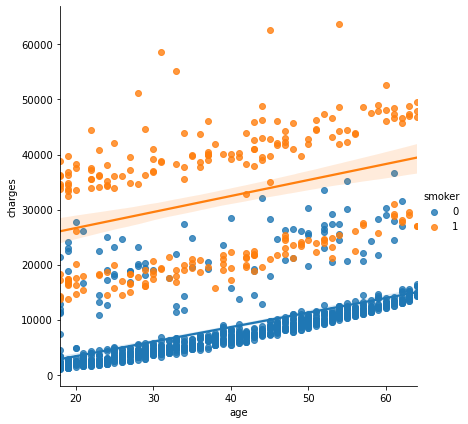

In [15]:
sns.lmplot(x='age', y='charges', hue='smoker', data=train, size=6);

<b>Как видно в целом медицинские расходы с возрастом возрастают. Далее проанализируем bmi (body mass index) параметр, который отражает соотношение массы и роста тела человека.

### $bmi=\frac{m}{h^2}$

m - масса тела, кг  
h - рост, м

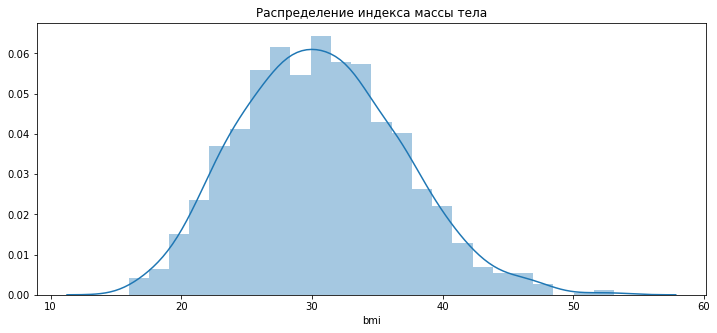

In [16]:
fig = plt.figure(figsize=(12,5))
sns.distplot(train['bmi']);
plt.title('Распределение индекса массы тела');

<b>Как видно из графика распределения индекса массы тела средняя величина равна 30, что соответсвтует началу ожирения. Нормой считается от 18.5 до 25.

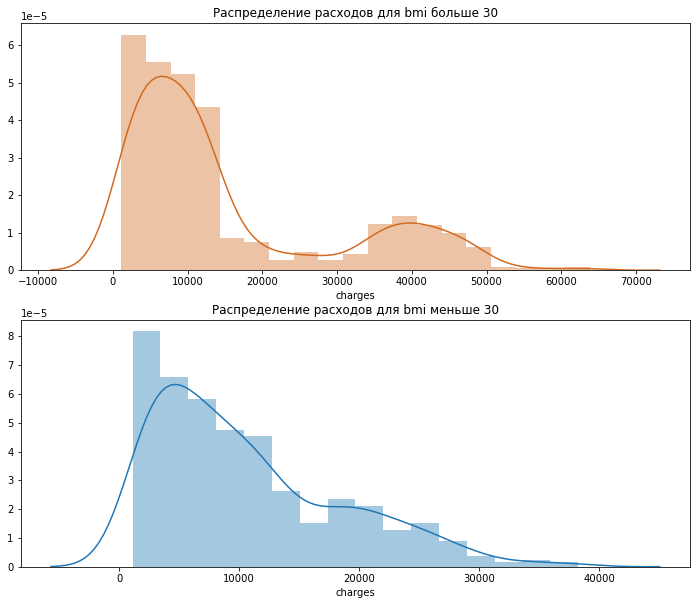

In [17]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(211)
sns.distplot(train[train['bmi'] > 30]['charges'], color='chocolate', ax=ax);
ax.set_title('Распределение расходов для bmi больше 30')

ax = fig.add_subplot(212)
sns.distplot(train[train['bmi'] < 30]['charges'], ax=ax);
ax.set_title('Распределение расходов для bmi меньше 30');

<b>Пациенты, у которых индекс массы тела выше 30 тратят на медицину больше чем, те у которых индекс меньше 30.

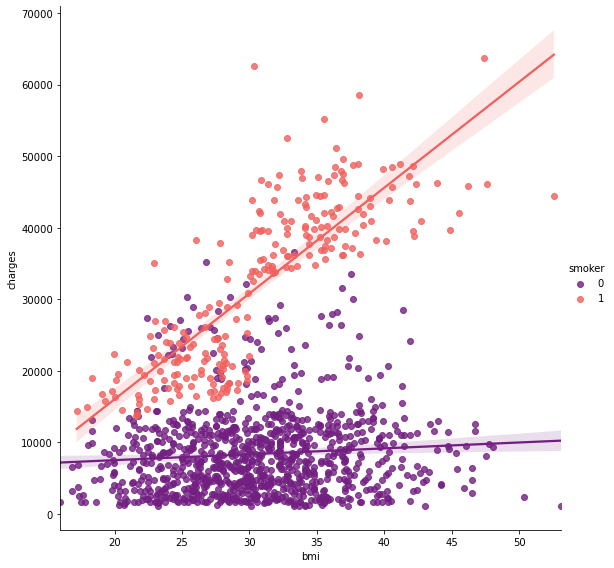

In [18]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=train, palette = 'magma', size = 8);

<b>Далее рассмотрим колонку children:

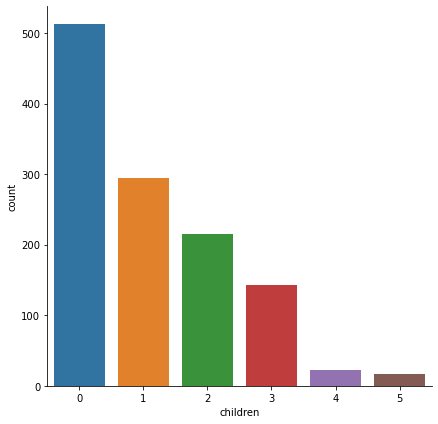

In [19]:
sns.catplot(x='children', kind='count', data=train, size=6);

<b>Как видно, около половины пациентов не имеют детей.

# Построение модели

### Линейная регрессия

In [20]:
X_train = train.drop('charges', axis=1)
Y_train = train['charges']
X_test = test.drop('charges', axis=1)

In [21]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (1204, 6)
Y_train shape:  (1204,)
X_test shape:  (133, 6)


In [22]:
targets = test['charges']

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, Y_train)
Y_pred = linear_regressor.predict(X_test)

print(f"Coeffictient of determination is {round(r2_score(targets, Y_pred),2)}")

Coeffictient of determination is 0.78


<b>Коэффициент детерминации линейной регрессии $R^2$=0.78, что уже не плохо.

### Множественная полиномиальная регрессия

In [23]:
polynomial_feature = PolynomialFeatures(degree=2)
pol_features_train = polynomial_feature.fit_transform(X_train)
pol_features_test = polynomial_feature.fit_transform(X_test)

linear_regressor.fit(pol_features_train, Y_train)
Y_pred_pol = linear_regressor.predict(pol_features_test)
print(f"Coeffictient of determination is {round(r2_score(targets, Y_pred_pol),2)}")

Coeffictient of determination is 0.85


<b>Коэффициент детерминации множественной полиномиальной регрессии второй степени равен $R^2$=0.85.

### Регрессия случайного леса (Random forest regression)

In [24]:
forest_regressor = RandomForestRegressor(n_estimators = 100, criterion = 'mse', random_state = 1, n_jobs = -1)
forest_regressor.fit(X_train, Y_train)
Y_pred_forest = forest_regressor.predict(X_test)

print(f'Mean squared error:{round(mean_squared_error(targets,Y_pred_forest),2)}')
print(f'Root mean squared error:{round(mean_squared_error(targets,Y_pred_forest, squared=False),2)}')
print(f'Mean absolute error:{round(mean_absolute_error(targets,Y_pred_forest),2)}')
r2 = r2_score(targets,Y_pred_forest)
n = len(targets)
k = 1
print(f'Coeficient of determination:{round(r2,2)}')
print(f'Adjusted coeficient of determination:{round(1-(((n-1)/(n-k-1))*(1-r2)),2)}')

Mean squared error:20267598.48
Root mean squared error:4501.95
Mean absolute error:2344.04
Coeficient of determination:0.88
Adjusted coeficient of determination:0.87


<b>Как видно коэффициент детерминации регрессии случайного леса равен 0.88.

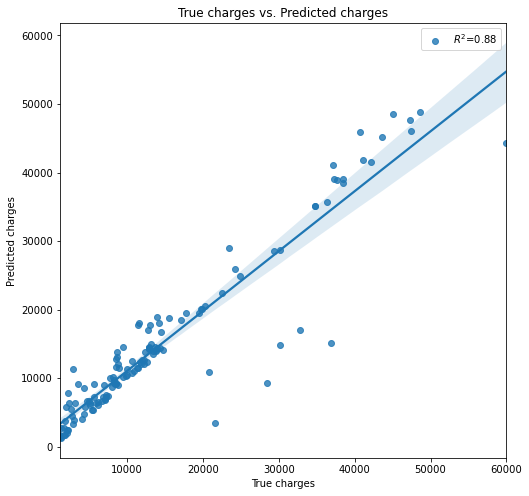

In [25]:
fig = plt.figure(figsize=(8,8))
sns.regplot(targets, Y_pred_forest, label=f'$R^2$={round(r2,2)}');
plt.title('True charges vs. Predicted charges');
plt.xlabel('True charges');
plt.ylabel('Predicted charges');
plt.legend(loc='best');

<b> Вывод: Курение - наибольший фактор (исходя из представленных данных), который влияет на медицинские расходы, после этого идут индекс массы тела и возраст. А также, регрессия случайного леса оказалась лучшей моделью для предсказания медицинских расходов с коэфициентом регрессии равным 0.88.